## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from numpy import concatenate
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from technicalindicators import TechnicalIndicators
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import keras

## Adding technical indicators

In [2]:
TI=TechnicalIndicators()
close_data=TI.close_data[['4. close']]
macd_data=TI.macd_data
rsi_data=TI.rsi_data
bbands_data=TI.bbands_data

Enter stock name:TSLA


## Predicting data

In [3]:
dataset = pd.concat([macd_data,rsi_data,bbands_data,close_data], axis=1,sort=True).reindex(macd_data.index)
dataset = dataset.sort_values('date', ascending=True)
dataset=dataset.drop(dataset.index[len(dataset)-1])
dataset = dataset.rename(columns = {'4. close':'Close'})
close_data = dataset[['Close']]

## Seperating train and test data

In [4]:
X=dataset.drop(dataset.index[len(dataset)-1])
y=close_data.drop(close_data.index[0])

In [5]:
values_x=X.values
values_y=y.values

## Standardizing data and splitting train and test data

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_X = scaler.fit_transform(values_x)
scaled_data_y = scaler.fit_transform(values_y)
X_train=scaled_data_X[:int(X.shape[0]*0.8)]
X_test= scaled_data_X[int(y.shape[0]*0.8):]
y_train=scaled_data_y[:int(X.shape[0]*0.8)]
y_test=scaled_data_y[int(y.shape[0]*0.8):]

In [7]:
X_train=np.array(X_train)
X_test=np.array(X_test)
y_train=np.array(y_train)
y_test=np.array(y_test)
X_train=X_train.reshape(X_train.shape[0],1,X_train.shape[1])
X_test=X_test.reshape(X_test.shape[0],1,X_test.shape[1])
y_train=y_train.reshape(y_train.shape[0],1,1)
y_test=y_test.reshape(y_test.shape[0],1,1)
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(2143, 1, 8) (2143, 1, 1) (536, 1, 8) (536, 1, 1)


In [8]:
a_train,b_train,c_test,d_test =[],[],[],[]
for i in range(60,y_train.shape[0]):
    a_train.append(X_train[i-60:i,0])
    b_train.append(y_train[i,0])
for x in range(60,y_test.shape[0]):
    c_test.append(X_test[x-60:x,0])
    d_test.append(y_test[x,0])
a_train, b_train,c_test,d_test = np.array(a_train), np.array(b_train),np.array(c_test),np.array(d_test)
a_train = np.reshape(a_train, (a_train.shape[0],a_train.shape[1],8))
b_train=np.reshape(b_train,(b_train.shape[0],b_train.shape[1]))
c_test=np.reshape(c_test,(c_test.shape[0],c_test.shape[1],8))
d_test=np.reshape(d_test,(d_test.shape[0],d_test.shape[1]))

In [9]:
print(a_train.shape, b_train.shape, c_test.shape, d_test.shape)

(2083, 60, 8) (2083, 1) (476, 60, 8) (476, 1)


## Defining LSTM models and fitting train data to it

Epoch 1/50
35/35 [==============================] - 1s 32ms/step - loss: 0.0022 - val_loss: 0.0216
Epoch 2/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0044 - val_loss: 0.0313
Epoch 3/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0031 - val_loss: 0.0221
Epoch 4/50
35/35 [==============================] - 0s 11ms/step - loss: 0.0030 - val_loss: 0.0217
Epoch 5/50
35/35 [==============================] - 0s 10ms/step - loss: 0.0029 - val_loss: 0.0218
Epoch 6/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0328
Epoch 7/50
35/35 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0394
Epoch 8/50
35/35 [==============================] - 0s 9ms/step - loss: 4.3739e-04 - val_loss: 0.0367
Epoch 9/50
35/35 [==============================] - 0s 9ms/step - loss: 2.4512e-04 - val_loss: 0.0351
Epoch 10/50
35/35 [==============================] - 0s 9ms/step - loss: 1.8875e-04 - val_loss: 0.0350
Epo

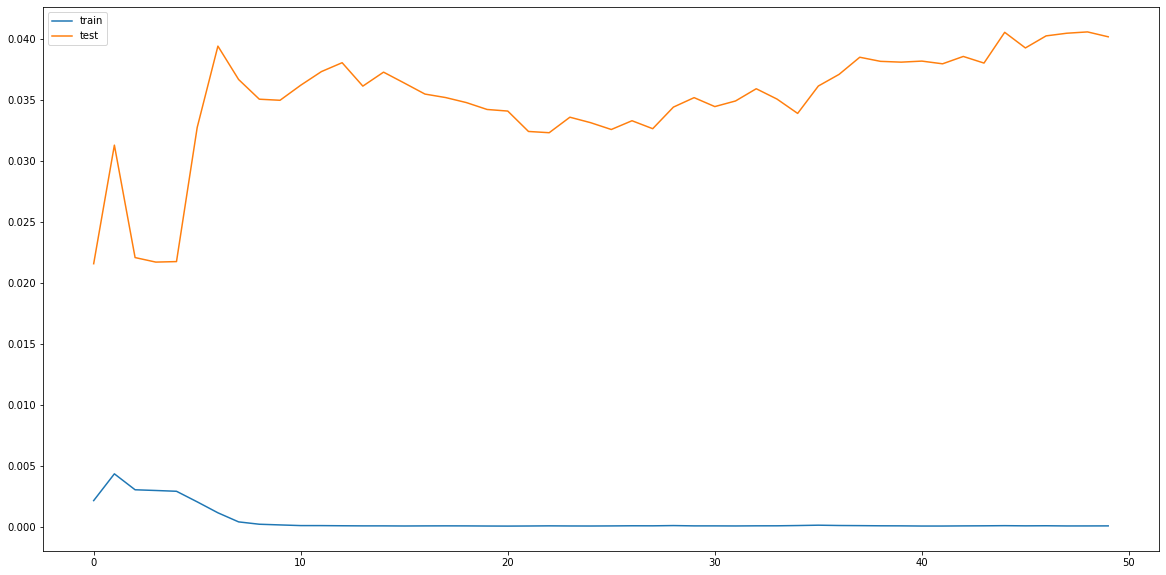

In [10]:
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(a_train.shape[1],a_train.shape[2])))
model.add(LSTM(units=100))
model.add(Dropout(0.4))
model.add(Dense(1))
ADAM=keras.optimizers.Adam(0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=ADAM)
history = model.fit(a_train,b_train,epochs=50,batch_size=60,validation_data=(c_test,d_test),verbose=1,shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Predicting on test data and calcuting error

In [11]:
yhat = model.predict(c_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat,X_test[60:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test[60:],X_test[60:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 445.049


In [1]:
## Plotting test actual and forecast prices

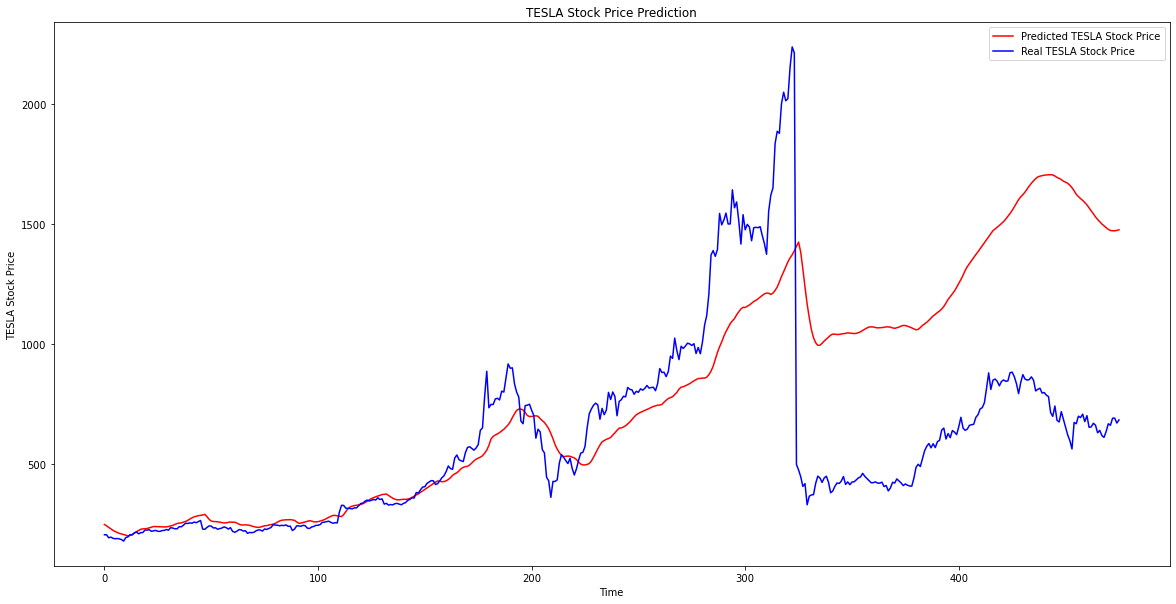

In [12]:
plt.plot(inv_yhat,color = 'red', label = 'Predicted TESLA Stock Price')
plt.plot(inv_y,color = 'blue', label = 'Real TESLA Stock Price')
plt.title('TESLA Stock Price Prediction')
plt.legend()
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.show()

In [13]:
train = dataset.iloc[0:int(dataset.shape[0]*0.8)+60,:]
valid = dataset.iloc[int(dataset.shape[0]*0.8)+60:,:]

In [14]:
valid['Predicted'] = inv_yhat

<ipython-input-14-0e3666a164d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predicted'] = inv_yhat


## Plotting actual and forecast prices

<ipython-input-37-02d0d6a0ebe3>:6: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend(line2,handles=[patch],loc=2,fontsize=10)


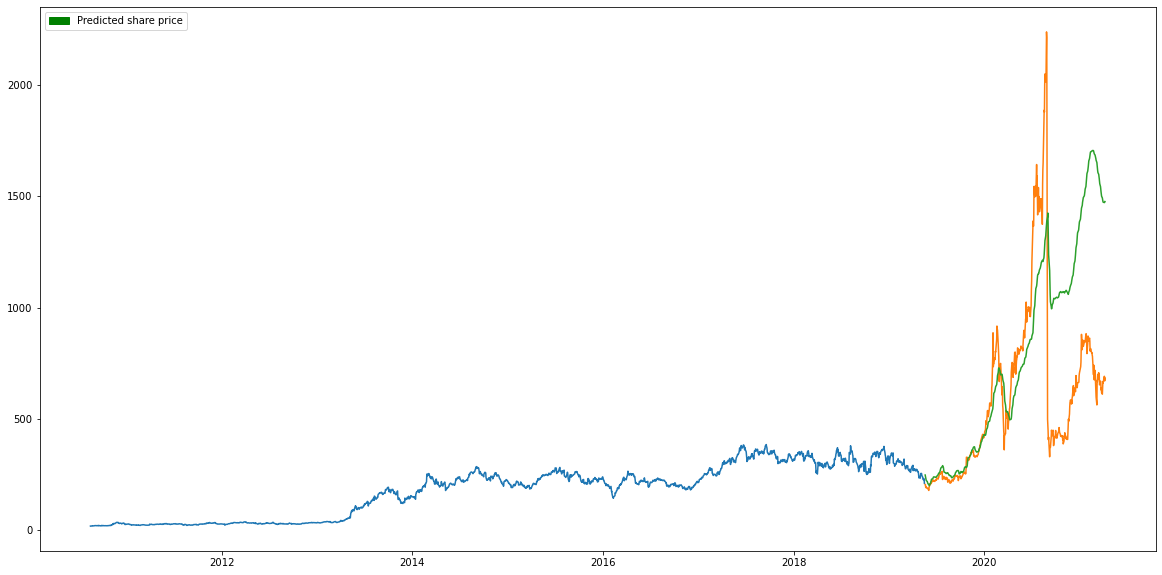

In [37]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
line2=plt.plot(valid['Predicted'])
import matplotlib.patches as mpatches
patch=mpatches.Patch(color='green', label='Predicted share price')
plt.legend(line2,handles=[patch],loc=2,fontsize=10)
plt.show()